In [2]:
import numpy as np
import pandas as pd
from itertools import product

test data creators

In [3]:
def matrix_creator(states_number: int) -> np.array:
    matrix = np.random.rand(states_number, states_number)
    row_sums = matrix.sum(axis=1)
    P = matrix / row_sums[:, np.newaxis]
    return P

In [4]:
def observations_creator_stationary(P: np.array, n: int, starting_state: int, states_number: int) -> list:
    observations = [starting_state]
    for i in range(n):
        observations.append(np.random.choice(states_number,p=P[observations[i]]))
    return observations
            

In [5]:
def matrix_sequence(n_matrixes, states_number, duration) -> list:
    seq = []
    for i in range(n_matrixes):
        mat = matrix_creator(states_number)
        for j in range(np.random.choice(duration)): seq.append(mat)
    return seq

In [6]:
def observations_creator(seq_of_matrixes: list, num_steps: int, starting_state: int, states_number: int) -> list:
    observations = [starting_state]
    for i in range(num_steps):
        observations.append(np.random.choice(states_number,p = seq_of_matrixes[i][observations[i]]))
    return observations
            

In [7]:
def matrix_path(start: int, end: int, speed_func, num_steps: int) -> list:
    vector: int = end - start
    path = []
    for t in range(num_steps + 1):
        path.append(start + speed_func(t/num_steps) * vector)
    return path

path = matrix_path(matrix_creator(2), matrix_creator(2), lambda x: x, 5)
path    

[array([[0.67021611, 0.32978389],
        [0.2549311 , 0.7450689 ]]),
 array([[0.71584135, 0.28415865],
        [0.25552975, 0.74447025]]),
 array([[0.76146658, 0.23853342],
        [0.2561284 , 0.7438716 ]]),
 array([[0.80709181, 0.19290819],
        [0.25672705, 0.74327295]]),
 array([[0.85271704, 0.14728296],
        [0.25732569, 0.74267431]]),
 array([[0.89834227, 0.10165773],
        [0.25792434, 0.74207566]])]

In [8]:
alphas = np.random.rand(3) 
a = np.random.default_rng().dirichlet(np.array(alphas), 3)
alphas, a

(array([0.97950718, 0.59130864, 0.2374589 ]),
 array([[9.98791626e-01, 1.17294250e-03, 3.54310739e-05],
        [9.72804922e-01, 2.69101240e-02, 2.84954159e-04],
        [4.11633508e-01, 5.38253461e-02, 5.34541146e-01]]))

In [9]:
P = matrix_creator(3)
obs = observations_creator_stationary(P, 10, 0 , 3)
P, obs

(array([[0.34046393, 0.52153151, 0.13800456],
        [0.22783083, 0.45604296, 0.31612621],
        [0.19890668, 0.41743903, 0.3836543 ]]),
 [0, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1])

In [10]:
seq = matrix_sequence(4,2,10)
obs = observations_creator(seq, 9, 0, 2)
obs

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]

functions for estimation

In [11]:
def distance(A: np.array, B: np.array) -> float:
    return np.sum((A - B)**2)

In [12]:
def func1(x): 
    return np.exp(-4*x)

def func2(x): 
    return np.exp((-4)*(x**2))

def func3(x) :
    if x < 1: return np.exp(1/(x**2-1))
    else: return 0

def func4(x: float) :
    a = 1 - x
    if a < 0: return 0
    else: return a

def func5(x):
    if x > 1: return 0
    else: return 1

In [13]:
def estimator(func, step: int, obs: list, states_number: int) -> np.array:
    """ Finds estimated matrix """
    P = np.zeros((states_number, states_number))
    for i in range(states_number):
        sums = np.zeros(states_number)
        quot = 0
        num = len(obs)
        for t in range(num-1):
            if obs[t] == i:
                quot += func(1-t*step/num)
                sums[obs[t+1]] += func(1-t*step/num)

        if quot!= 0: P[i] = sums/quot
    return P

sliding window estimation

In [14]:
def prob(j: int, size: int, window: list) :
    p = 0
    for k in range(size):
        try:
            if window[k] == j: p += 1
        except: break
    return p/size

In [15]:
def sliding_window(obs: list, states_number: int, sizes_number: int, step: int, min_size: int) -> np.array:
    prob_windows = np.empty((states_number,states_number,sizes_number),dtype=object)
    windows = np.empty(states_number, dtype=object)
    for set_of_nums in product(range(states_number), range(states_number), range(sizes_number)): 
        i, j, k = set_of_nums
        windows[i] = []
        prob_windows[i][j][k] = []
                
    matrix = np.zeros((states_number,states_number))

    for t in range(1 , len(obs)-1, 1):
        i , j = obs[t-1], obs[t]
        windows[i].insert(0, j)
        for k in range(sizes_number):
            current_size =  min_size+step*k
            proba = prob(j, current_size, windows[i])
            prob_windows[i][j][k].insert(0, proba)


    for set_of_nums in product(range(states_number), range(states_number)): 
        i, j = set_of_nums
        try:
            matrix[i][j] = prob_windows[i][j][sizes_number-1][0]
        except: pass
        for k in range(sizes_number):      
            current_size = min(min_size+step*k, len(prob_windows[i][j][k]))
            est_var = sum(prob_windows[i][j][k][0:current_size:])/current_size
            est_var = (((np.array(prob_windows[i][j][k]) - est_var)**2)[0:current_size:].sum())/(current_size -1)
            ac_var = (prob_windows[i][j][k][0]*(1 -  prob_windows[i][j][k][0]))/ current_size 
            if est_var > ac_var:
                matrix[i][j] = prob_windows[i][j][k][0]
                break
    return matrix 

In [16]:
def prob_new(func, j: int, size: int, window: list):
    p, quot, end = 0, 0, min(size, len(window))
    
    for k in range(end):
        try:
            quot+= func(1 - window[k][1]/end)
            if window[k][0] == j:
                p += func(1 - window[k][1]/end)
        except: break
    return p/quot

In [17]:
def sliding_kernel(func, obs: list, states_number: int, sizes_number: int, step: int, min_size: int) -> np.array:
    prob_windows = np.empty((states_number,states_number,sizes_number),dtype=object)
    windows = np.empty(states_number, dtype=object)
    for set_of_nums in product(range(states_number), range(states_number), range(sizes_number)): 
        i, j, k = set_of_nums
        windows[i] = []
        prob_windows[i][j][k] = []
                
    matrix = np.zeros((states_number,states_number))

    for t in range(1 , len(obs)-1, 1):
        i , j = obs[t-1], obs[t]
        windows[i].insert(0, [j,t])
        for k in range(sizes_number):
            current_size =  min_size+step*k
            proba = prob_new(func, j, current_size, windows[i])
            prob_windows[i][j][k].insert(0, proba)


    for set_of_nums in product(range(states_number), range(states_number)): 
        i, j = set_of_nums
        try:
            matrix[i][j] = prob_windows[i][j][sizes_number-1][0]
        except: pass
        for k in range(sizes_number):      
            current_size = min(min_size+step*k, len(prob_windows[i][j][k]))
            est_var = sum(prob_windows[i][j][k][0:current_size:])/current_size
            est_var = (((np.array(prob_windows[i][j][k]) - est_var)**2)[0:current_size:].sum())/(current_size -1)
            ac_var = (prob_windows[i][j][k][0]*(1 -  prob_windows[i][j][k][0]))/ current_size 
            if est_var > ac_var:
                matrix[i][j] = prob_windows[i][j][k][0]
                break
    return matrix 

Different functions and chains comparison

No stationary period:

In [ ]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**2, 3000 )
    for j in range(3000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2]:
        new_str.append(distance(path[-1], sliding_kernel(func, obs, 3, 99, 60, 60 )))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 60, 60 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'sliding window':[new_str[2]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

In [ ]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x, 10000 )
    for j in range(1000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 110, 110 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

In [ ]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x, 5000 )
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 110, 110 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

C:\Users\akash\AppData\Local\Temp\ipykernel_3212\3076598843.py:21: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, _ in dist.iteritems():


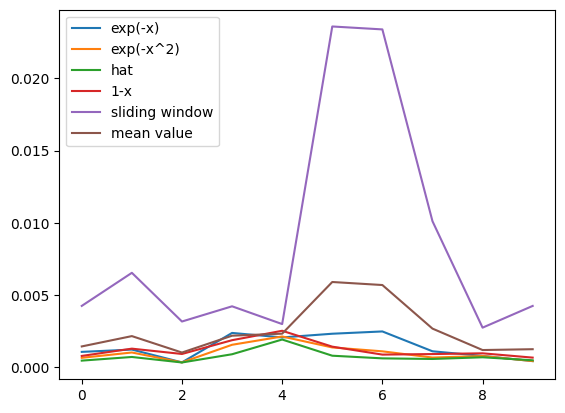

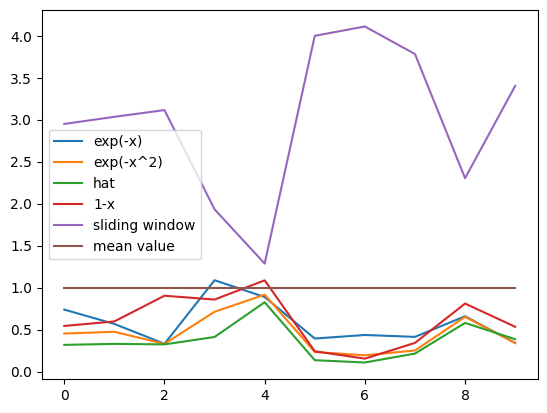

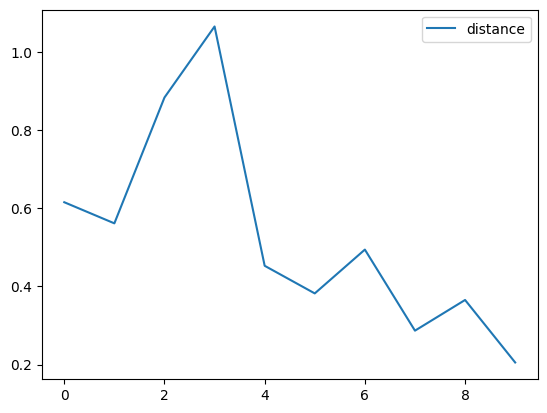

In [28]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x, 3000 )
    for j in range(6000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 90, 90 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

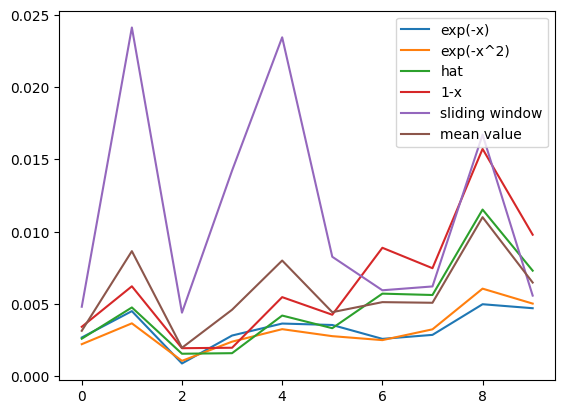

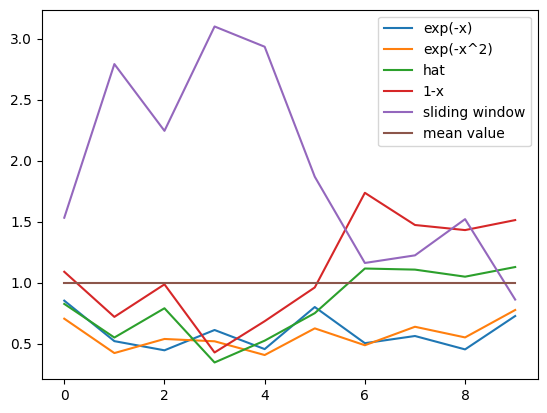

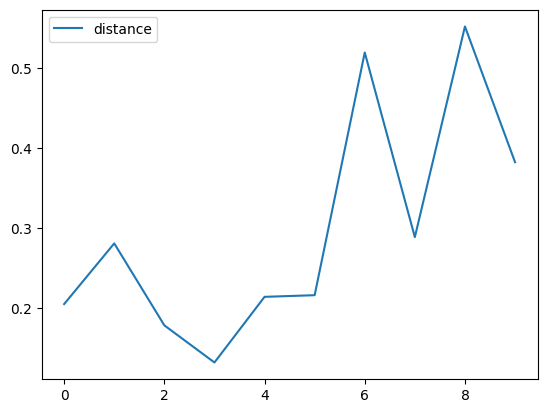

In [30]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**2, 3000 )
    for j in range(3000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 60, 60 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

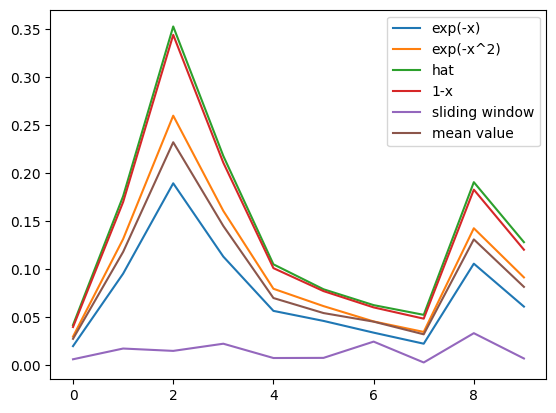

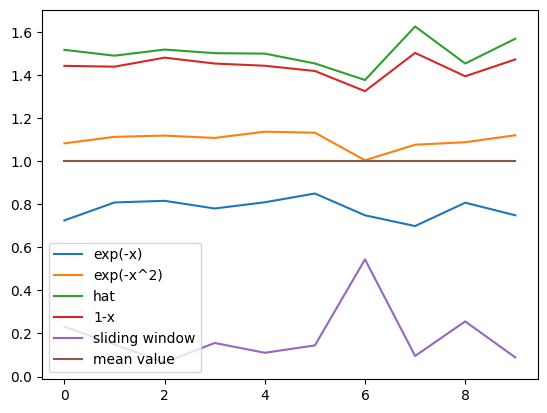

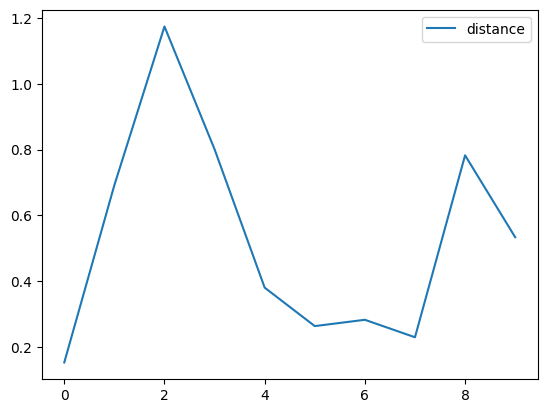

In [31]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**2, 10000 )
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 100, 100 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

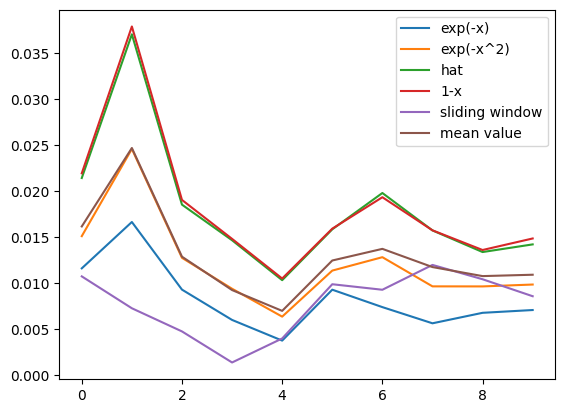

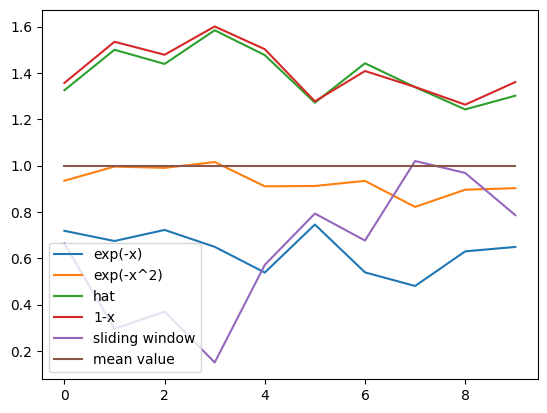

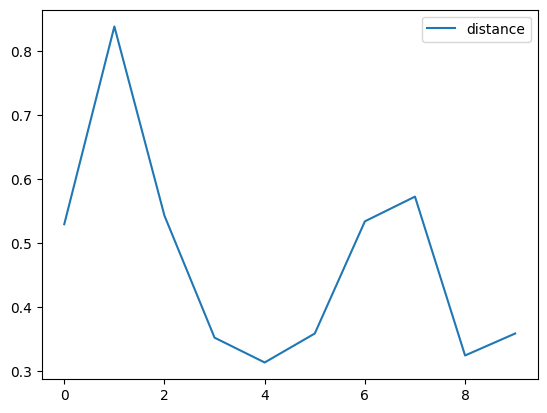

In [32]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**(0.5), 10000 )
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 100, 100 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

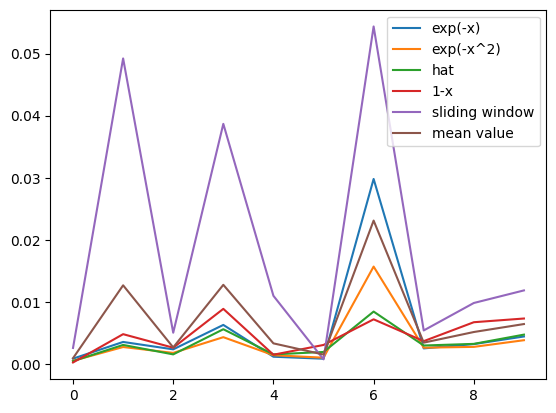

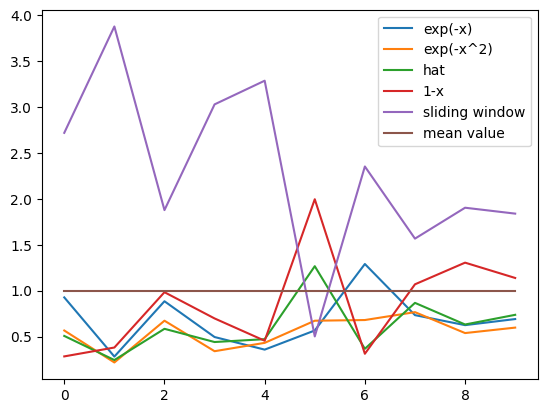

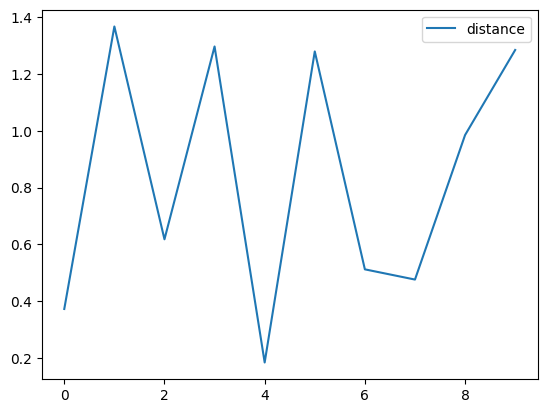

In [47]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
    a,b = matrix_creator(3),matrix_creator(3)
    matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    path = matrix_path(a,b,lambda x: x**(0.5), 3000 )
    for j in range(3000): path.append(path[-1])
    obs = observations_creator(path, len(path), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(path[-1], estimator(func,1, obs,len(path[-1][0]))))
    new_str.append(distance(path[-1], sliding_window(obs, 3, 99, 60, 60 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
plot3 = matrixes.plot.line()

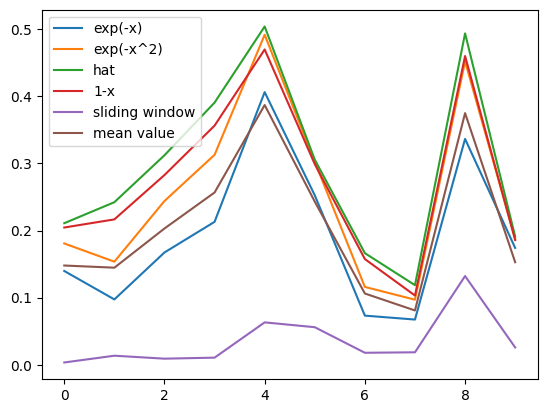

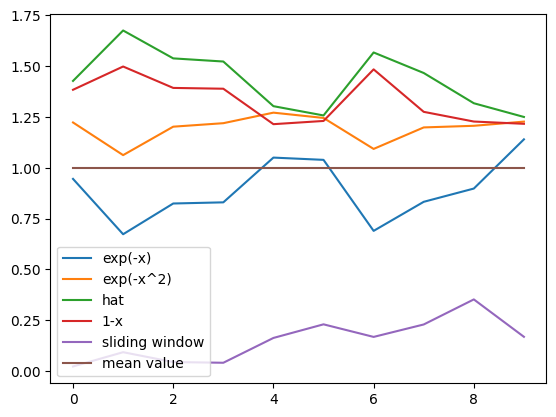

In [33]:

dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
#matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
   # matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    seq = matrix_sequence(10, 3, 1000)
    obs = observations_creator(seq, len(seq), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(seq[-1], estimator(func,1, obs,len(seq[-1][0]))))
    new_str.append(distance(seq[-1], sliding_window(obs, 3, 99, 90, 90 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
#plot3 = matrixes.plot.line()


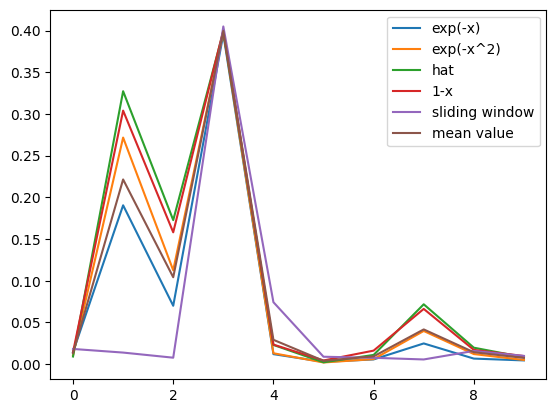

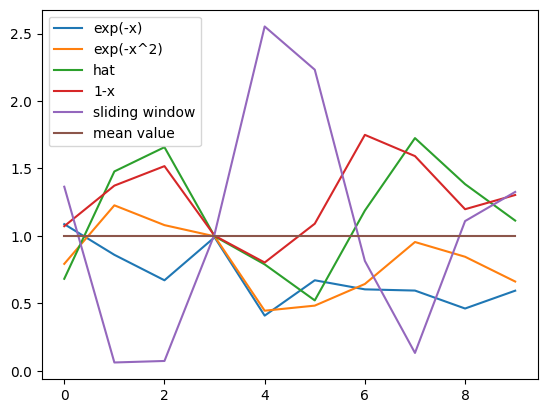

In [34]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
#matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
   # matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    seq = matrix_sequence(2, 3, 5000)
    obs = observations_creator(seq, len(seq), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(seq[-1], estimator(func,1, obs,len(seq[-1][0]))))
    new_str.append(distance(seq[-1], sliding_window(obs, 3, 99, 90, 90 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
#plot3 = matrixes.plot.line()


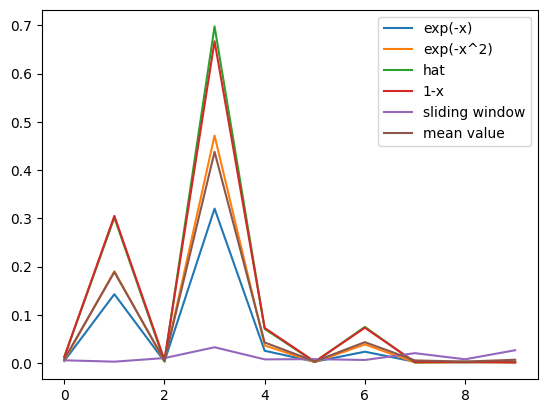

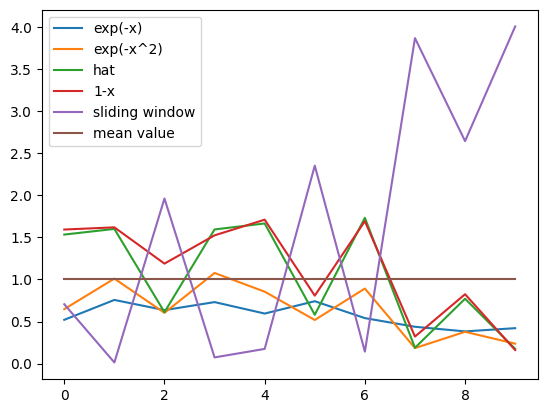

In [45]:
dist = pd.DataFrame({'exp(-x)':[], 'exp(-x^2)':[], 'hat':[], '1-x':[], 'sliding window':[]})
#matrixes = pd.DataFrame({'distance':[]})
for i in range(10):
   # matrixes = pd.concat([matrixes,pd.DataFrame({'distance':[ distance(a,b)]})])
    seq = matrix_sequence(2, 3, 5000)
    obs = observations_creator(seq, len(seq), 0, 3)
    new_str = []
    for func in [func1,func2,func3,func4]:
        new_str.append(distance(seq[-1], estimator(func,1, obs,len(seq[-1][0]))))
    new_str.append(distance(seq[-1], sliding_window(obs, 3, 99, 90, 90 )))
    new_str = pd.DataFrame({'exp(-x)':[new_str[0]], 'exp(-x^2)':[new_str[1]], 'hat':[new_str[2]], '1-x':[new_str[3]], 'sliding window':[new_str[4]]})
    dist = pd.concat([dist, new_str])
    
dist.index = np.arange(len(dist))
matrixes.index = np.arange(len(matrixes))
dist['mean value'] = dist.mean(axis=1)

plot1 = dist.plot.line()
for name, _ in dist.items():
    dist[name] = dist[name]/dist['mean value']
    
plot2 = dist.plot.line()
#plot3 = matrixes.plot.line()
